# Imports
## Author: Mrinmoy Sarkar
## email: mrinmoy.pol@gmail.com, msarkar@aggies.ncat.edu

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, precision_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Activation, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import LambdaCallback
from pickle import dump
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore')

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
# sess = tf.Session(config=config) 
# tf.keras.backend.set_session(sess)

# Data Preprocessing

In [13]:
profile_spec_path = './logs/profiles_eval_sample/'
performance_metrics = ['profile_flight_conditions_', 'profile_aircraft_electronics_',
                       'profile_aerodynamic_coefficients_', 'profile_electric_motor_and_propeller_efficiencies_']
mission_spec_df = None
evtol_performance_data_dic = {}
sample_index = 0

file_spec_names = []
for root, dirs, files in os.walk(profile_spec_path):
    for file in files:
        if 'profile_spec' in file:
            file_spec_names.append(file)

train_files, test_files = train_test_split(file_spec_names, test_size=0.15)

print(len(train_files), len(test_files))

#create train dataset
for file in train_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            performance_df = pd.read_csv(performance_path)
            performance_df = performance_df.fillna(0)
            outputs.append(performance_df.copy())
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 'outputs':outputs}
        sample_index += 1
        
#create test dataset
test_evtol_performance_data_dic = {}
sample_index = 0
for file in test_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            performance_df = pd.read_csv(performance_path)
            performance_df = performance_df.fillna(0)
            outputs.append(performance_df.copy())
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        test_evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 'outputs':outputs}
        sample_index += 1

print(len(evtol_performance_data_dic))
print(len(test_evtol_performance_data_dic))

81 15
80
15


In [14]:
segment_types = ['hover_climb', 'dep_transition', 'second_climb',
       'departure_terminal_procedures', 'accel_climb', 'cruise', 'decel_descend',
       'arrival_terminal_procedure', 'second_descent', 'app_transition',
       'hover_descent']
segment_weights = {'hover_climb':2, 'dep_transition':2, 'second_climb':2,
       'departure_terminal_procedures':2, 'accel_climb':2, 'cruise':1, 'decel_descend':2,
       'arrival_terminal_procedure':2, 'second_descent':2, 'app_transition':2,
       'hover_descent':2}
segment_types = [[i] for i in segment_types]
segment_type_encoder = OneHotEncoder()
segment_type_encoder.fit(segment_types)

def get_one_hot_encode_segment(x):
    if 'cruise' in x:
        return segment_type_encoder.transform([['cruise']]).toarray()[0]
    else:
        return segment_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_segment('hover_climb'))

evtol_types = ['lift_and_cruse', 'vector_thrust', 'multicopter']
evtol_types = [[i] for i in evtol_types]

evtol_type_encoder = OneHotEncoder()
evtol_type_encoder.fit(evtol_types)

def get_one_hot_encode_evtol(x):
    return evtol_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_evtol('lift_and_cruse'))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0.]


In [47]:
def get_dataX():
    data_X = None
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_dataY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_Y

def get_datatestX():
    data_X = None
    for key in range(len(test_evtol_performance_data_dic)):
        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_datatestY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(test_evtol_performance_data_dic)):
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_Y

def get_data_for_inference(performance):
    data_X = None
    key = np.random.randint(0, len(test_evtol_performance_data_dic))
    
    X = None
    x = test_evtol_performance_data_dic[key]['input']
    evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
    for i in range(x.shape[0]):
        x_row = x.iloc[i].to_numpy()
        x1 = get_one_hot_encode_evtol(evtol_type)
        x2 = get_one_hot_encode_segment(x_row[0])
        x3 = x_row[1:].astype('float64')
        x_row = np.concatenate((x1,x2,x3))
        X = x_row if X is None else np.vstack((X,x_row))
    data_X = X if data_X is None else np.vstack((data_X, X))
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    Y = None
    y = test_evtol_performance_data_dic[key]['outputs'][indx]
    for i in range(0,y.shape[0],8):
        y_row = y.iloc[i:i+8].to_numpy()
        y_row = y_row[:, 2:].astype('float64')
        y_row = np.mean(y_row, axis=0)
        Y = y_row if Y is None else np.vstack((Y, y_row))
    data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_X, data_Y

def get_data_for_lstm(performance):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        yield X, Y
        
def get_data_for_lstm_idx(performance, idx):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        
        ii = list(range(x.shape[0]))
        jj = list(range(0,y.shape[0],8))
        ii = ii[0:-1]
        jj = jj[1:]
        
        for i,j in zip(ii,jj):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x4 = y.iloc[i:i+8].to_numpy()
            x4 = x4[:, idx].astype('float64')
            x4 = [np.mean(x4, axis=0)]
            
            x_row = np.concatenate((x1,x2,x3,x4))
            
            y_row = y.iloc[j:j+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            
            X = x_row if X is None else np.vstack((X,x_row))
            Y = y_row if Y is None else np.vstack((Y, y_row))
            
        yield X, Y
        
def get_data_for_lstm_train(performance, idx):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    data_X = None
    data_Y = None
    for key in range(len(evtol_performance_data_dic)):
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue
#         print(x4)

        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))

    return data_X, data_Y

def get_data_for_lstm_test(performance, idx):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    data_X = None
    data_Y = None
    for key in range(len(test_evtol_performance_data_dic)):
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue
#         print(x4)

        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))

    return data_X, data_Y

def get_data_for_lstm_inference(performance, idx, init_key=-1):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    
    for _ in range(100):
        key = np.random.randint(0, len(test_evtol_performance_data_dic)) if init_key==-1 else init_key
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue

        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
            
        return X, Y, key

    return None, None

In [16]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)
testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)

(6096, 22)
(6096, 6)
(19, 22) (19, 6)


# Test Data Preprocessing Code

0.019749826431873452


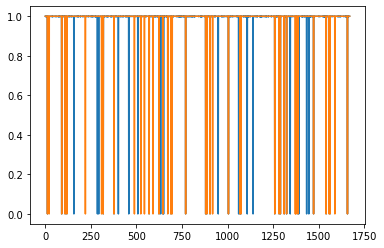

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.3, random_state=42)
regr_1 = DecisionTreeRegressor(max_depth=32)
regr_1.fit(X_train, y_train[:,5])
y_1 = regr_1.predict(X_test)
plt.plot(y_1)
plt.plot(y_test[:,5])
err1 = mean_squared_error(y_test[:,5],y_1)
print(err1)

# Results Dictionary Definition

In [21]:
criterias_lst = ["MAE", "MSE", "RMSE", "MAPE"]
fesibility_criterias_lst = ['accuracy', 'f1', 'precision', 'recall']
# criterias = {"MAE":{}, "MSE":{}, "RMSE":{}, "MAPE":{}}
performance = {'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}} #criterias}
result = {'DT':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'ADBoost':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'GBoost':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'RF':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, }
#           'SVR':{'flight_conditions':{}, #criterias, 
#                'aircraft_electronics':{}, #criterias,
#                'aerodynamic_coefficients':{}, #criterias, 
#                'electric_motor_and_propeller_efficiencies':{}}, 
#           'MLP':{'flight_conditions':{}, #criterias, 
#                'aircraft_electronics':{}, #criterias,
#                'aerodynamic_coefficients':{}, #criterias, 
#                'electric_motor_and_propeller_efficiencies':{}}, 
#           'LSTM':{'flight_conditions':{}, #criterias, 
#                'aircraft_electronics':{}, #criterias,
#                'aerodynamic_coefficients':{}, #criterias, 
#                'electric_motor_and_propeller_efficiencies':{}}}
fesibility_result = {'DT':{'fesibility':{}}, 'ADBoost':{'fesibility':{}}, 
                     'GBoost':{'fesibility':{}}, 'RF':{'fesibility':{}}, }
#                      'SVC':{'fesibility':{}}, 'MLP':{'fesibility':{}}, 'LSTM':{'fesibility':{}}}
lstm_results = {'range':{}, 'battery_energy':{}, 'voltage':{}, 'current':{}}

# DecisionTreeRegressor

## Flight Conditions

In [8]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = DecisionTreeClassifier(max_depth=32)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['DT']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['DT']['fesibility']['f1'] = round(f1, 2)
fesibility_result['DT']['fesibility']['precision'] = round(precision, 2)
fesibility_result['DT']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9915857605177993


In [9]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
#     print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['DT']['flight_conditions'][outputs[output_indx]] = {}
    result['DT']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['DT']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['DT']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
    

# start_time = time.time()
# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# print('Inference Time {}s'.format(time.time()-start_time))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
0.04
412.29


## Aerodynamic Coefficients

In [10]:
dataX = get_dataX()
dataY = get_dataY('aerodynamic_coefficients')
datatestX = get_datatestX()
datatestY = get_datatestY('aerodynamic_coefficients')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['DT']['aerodynamic_coefficients'][outputs[output_indx]] = {}
    result['DT']['aerodynamic_coefficients'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['DT']['aerodynamic_coefficients'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['DT']['aerodynamic_coefficients'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        
# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()   

0.0
0.0
0.0
0.0


## Aircraft Electronics

In [11]:
dataX = get_dataX()
dataY = get_dataY('aircraft_electronics')
datatestX = get_datatestX()
datatestY = get_datatestY('aircraft_electronics')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['DT']['aircraft_electronics'][outputs[output_indx]] = {}
    result['DT']['aircraft_electronics'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['DT']['aircraft_electronics'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['DT']['aircraft_electronics'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

    
# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()
   

0.03
283.08
0.04
364.97
206.71
67.45
0.13
0.17
0.15


## Electric motor and propeller efficiencies 

In [12]:
dataX = get_dataX()
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
datatestX = get_datatestX()
datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

    
# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()
   

0.0
0.0
8.32
22.76
94.42
0.0
0.0
0.0
0.08
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# AdaBoostRegressor

## Flight Conditions

In [13]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=300, 
                         random_state=np.random.RandomState(1))
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['ADBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['ADBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['ADBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['ADBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9922330097087378


In [14]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
rng = np.random.RandomState(1)
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
for output_indx, i in enumerate([0,1,2,3]): #,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, random_state=rng)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['ADBoost']['flight_conditions'][outputs[output_indx]] = {}
    result['ADBoost']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['ADBoost']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['ADBoost']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        
            
# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()


0.0
0.01
0.0
171.75


## Aerodynamic Coefficients

In [15]:
dataX = get_dataX()
dataY = get_dataY('aerodynamic_coefficients')
datatestX = get_datatestX()
datatestY = get_datatestY('aerodynamic_coefficients')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]] = {}
    result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

        
# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
0.0
0.0


## Aircraft Electronics

In [16]:
dataX = get_dataX()
dataY = get_dataY('aircraft_electronics')
datatestX = get_datatestX()
datatestY = get_datatestY('aircraft_electronics')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['ADBoost']['aircraft_electronics'][outputs[output_indx]] = {}
    result['ADBoost']['aircraft_electronics'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['ADBoost']['aircraft_electronics'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['ADBoost']['aircraft_electronics'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.02
209.4
0.06
269.35
226.37
46.1
0.1
0.24
0.22


## Electric motor and propeller efficiencies

In [17]:
dataX = get_dataX()
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
datatestX = get_datatestX()
datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
    

# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
10.01
29.35
50.95
0.0
0.0
0.0
0.08
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# GradientBoostingRegressor

## Flight Conditions

In [18]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = GradientBoostingClassifier(random_state=0)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['GBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['GBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['GBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['GBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9922330097087378


In [19]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    
    

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['GBoost']['flight_conditions'][outputs[output_indx]] = {}
    result['GBoost']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['GBoost']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['GBoost']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

        
# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()


0.0
0.03
0.01
127.43


## Aerodynamic Coefficients

In [20]:
dataX = get_dataX()
dataY = get_dataY('aerodynamic_coefficients')
datatestX = get_datatestX()
datatestY = get_datatestY('aerodynamic_coefficients')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = abs(test_Y[:, i]) > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]] = {}
    result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
0.01
0.0


## Aircraft Electronics

In [21]:
dataX = get_dataX()
dataY = get_dataY('aircraft_electronics')
datatestX = get_datatestX()
datatestY = get_datatestY('aircraft_electronics')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = abs(test_Y[:, i]) > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['GBoost']['aircraft_electronics'][outputs[output_indx]] = {}
    result['GBoost']['aircraft_electronics'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['GBoost']['aircraft_electronics'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['GBoost']['aircraft_electronics'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.01
85.48
0.78
106.08
91.72
21.75
0.04
0.04
3.12


## Electric motor and propeller efficiencies

In [22]:
dataX = get_dataX()
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
datatestX = get_datatestX()
datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')


scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = abs(test_Y[:, i]) > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
    
    

# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
20.43
350.01
26.12
0.0
0.0
0.0
0.11
0.08
0.0
0.0
0.0
0.0
0.0
0.0


# RandomForestRegressor

## Flight Conditions

In [23]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = RandomForestClassifier(max_depth=8, random_state=0)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['RF']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['RF']['fesibility']['f1'] = round(f1, 2)
fesibility_result['RF']['fesibility']['precision'] = round(precision, 2)
fesibility_result['RF']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9553398058252427


In [24]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['RF']['flight_conditions'][outputs[output_indx]] = {}
    result['RF']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()


0.0
0.01
0.03
141.19


## Aerodynamic Coefficients

In [25]:
dataX = get_dataX()
dataY = get_dataY('aerodynamic_coefficients')
datatestX = get_datatestX()
datatestY = get_datatestY('aerodynamic_coefficients')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['RF']['aerodynamic_coefficients'][outputs[output_indx]] = {}
    result['RF']['aerodynamic_coefficients'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['aerodynamic_coefficients'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['aerodynamic_coefficients'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

        
# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
0.01
0.0


## Aircraft Electronics

In [26]:
dataX = get_dataX()
dataY = get_dataY('aircraft_electronics')
datatestX = get_datatestX()
datatestY = get_datatestY('aircraft_electronics')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['RF']['aircraft_electronics'][outputs[output_indx]] = {}
    result['RF']['aircraft_electronics'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['aircraft_electronics'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['aircraft_electronics'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.01
92.94
0.17
114.76
101.16
17.18
0.04
0.04
0.7


## Electric motor and propeller efficiencies

In [27]:
dataX = get_dataX()
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
datatestX = get_datatestX()
datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
    
        

# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
20.34
112.95
31.09
0.0
0.0
0.0
0.04
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# LSTM

## range, battery energy, voltage and current

In [50]:
%%time
@tf.autograph.experimental.do_not_convert
def mape_loss_fn(y_true, y_pred):
    indxes = y_true[:,0] > 10e-3
    y_true = y_true[indxes]
    y_pred = y_pred[indxes]
    mape = losses.mean_absolute_percentage_error(y_true, y_pred)
    return mape

performance_metrics = {'flight_conditions':[3], # range
                       'aircraft_electronics':[1, 3, 5], # battery energy, voltage, current
                       #'electric_motor_and_propeller_efficiencies':[3, 4] # propeller thrust, propeller torque
                      } 
# performance_metrics = {
#                        'aircraft_electronics':[5]
#                       } 
# training
performance_variable_names = {('flight_conditions',3):'range', 
                              ('aircraft_electronics',1):'battery_energy', 
                              ('aircraft_electronics',3):'voltage', 
                              ('aircraft_electronics',5):'current'}
model_dir = './ML_Models/'
trained_models_name = ['lstm_range.h5', 'lstm_battery_energy.h5', 'lstm_voltage.h5', 'lstm_current.h5']
model_idx = 0

for performance_metric in performance_metrics:
    for idx in performance_metrics[performance_metric]:
        dataX, dataY = get_data_for_lstm_train(performance_metric, idx)
        dataY = dataY[:,idx].reshape((-1,1))

        # deep LSTM model
        time_step = 1 
        num_feature = 23
        num_class = 1
        direction = 2
        neuron_size = 128
        lstm_layers = 1
        hidden_layer1 = 128
        hidden_layer2 = 512
        hidden_layer3 = 128
        epochs = 2000


        # create model
        x_in = Input(shape=(time_step, num_feature),dtype="float32")
        # bid_layer1 = Bidirectional(LSTM(neuron_size))(x_in)
        lstm_layer1 = LSTM(neuron_size)(x_in)
        fc1 = Dense(units=hidden_layer1, activation='relu')(lstm_layer1)
        fc2 = Dense(units=hidden_layer2, activation='relu')(fc1)
        fc3 = Dense(units=hidden_layer3, activation='relu')(fc2)
        y = Dense(units=num_class, activation='linear')(fc3)

        model = Model(inputs=x_in, outputs=y)
        optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        loss = losses.mse
        model.compile(optimizer=optimizer, loss=loss, metrics=['mse','mae', mape_loss_fn])
#         print(model.summary())


        input_data = dataX #dataX[:-time_step, :]
        targets = dataY #dataY[time_step:, :]
        dataset = timeseries_dataset_from_array(input_data, 
                                                targets, 
                                                sequence_length=time_step,
                                                batch_size=128)

        hist = model.fit(dataset,
                         epochs=epochs,
                         verbose=0,
                         callbacks=None,#[batch_print_callback],
                         max_queue_size=512,
                         workers=64,
                         use_multiprocessing=True,
                         shuffle=False
                        )
#         print(hist.history['loss'][-5:])
#         print("********")
        dataX, dataY = get_data_for_lstm_test(performance_metric, idx)
        dataY = dataY[:,idx].reshape((-1,1))
        input_data = dataX 
        targets = dataY 
        dataset = timeseries_dataset_from_array(input_data, 
                                                targets, 
                                                sequence_length=time_step,
                                                batch_size=128)
        scores = model.evaluate(dataset, return_dict=True)
        print(performance_metric, idx)
        print(scores)
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MSE'] = scores['mse']
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MAE'] = scores['mae']
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MAPE'] = scores['mape_loss_fn'] 
        
        model.save(model_dir+trained_models_name[model_idx])
        model_idx += 1


6/6 [==============================] - 1s 7ms/step - loss: 3.4125 - mse: 3.4125 - mae: 0.7165 - mape_loss_fn: 3.4795
flight_conditions 3
{'loss': 3.4124553203582764, 'mse': 3.4124553203582764, 'mae': 0.7165305018424988, 'mape_loss_fn': 3.479538679122925}
6/6 [==============================] - 1s 8ms/step - loss: 3.0926 - mse: 3.0926 - mae: 0.9704 - mape_loss_fn: 1.7664
aircraft_electronics 1
{'loss': 3.092578172683716, 'mse': 3.092578172683716, 'mae': 0.9704117178916931, 'mape_loss_fn': 1.766376256942749}
6/6 [==============================] - 1s 7ms/step - loss: 119.1255 - mse: 119.1255 - mae: 8.5712 - mape_loss_fn: 1.9236
aircraft_electronics 3
{'loss': 119.1255111694336, 'mse': 119.1255111694336, 'mae': 8.5712251663208, 'mape_loss_fn': 1.9235566854476929}
6/6 [==============================] - 1s 8ms/step - loss: 7.1316 - mse: 7.1316 - mae: 1.9676 - mape_loss_fn: 1.2164
aircraft_electronics 5
{'loss': 7.1315741539001465, 'mse': 7.1315741539001465, 'mae': 1.9676401615142822, 'mape_lo

CPU times: user 4.66 s, sys: 298 ms, total: 4.96 s
Wall time: 4.47 s


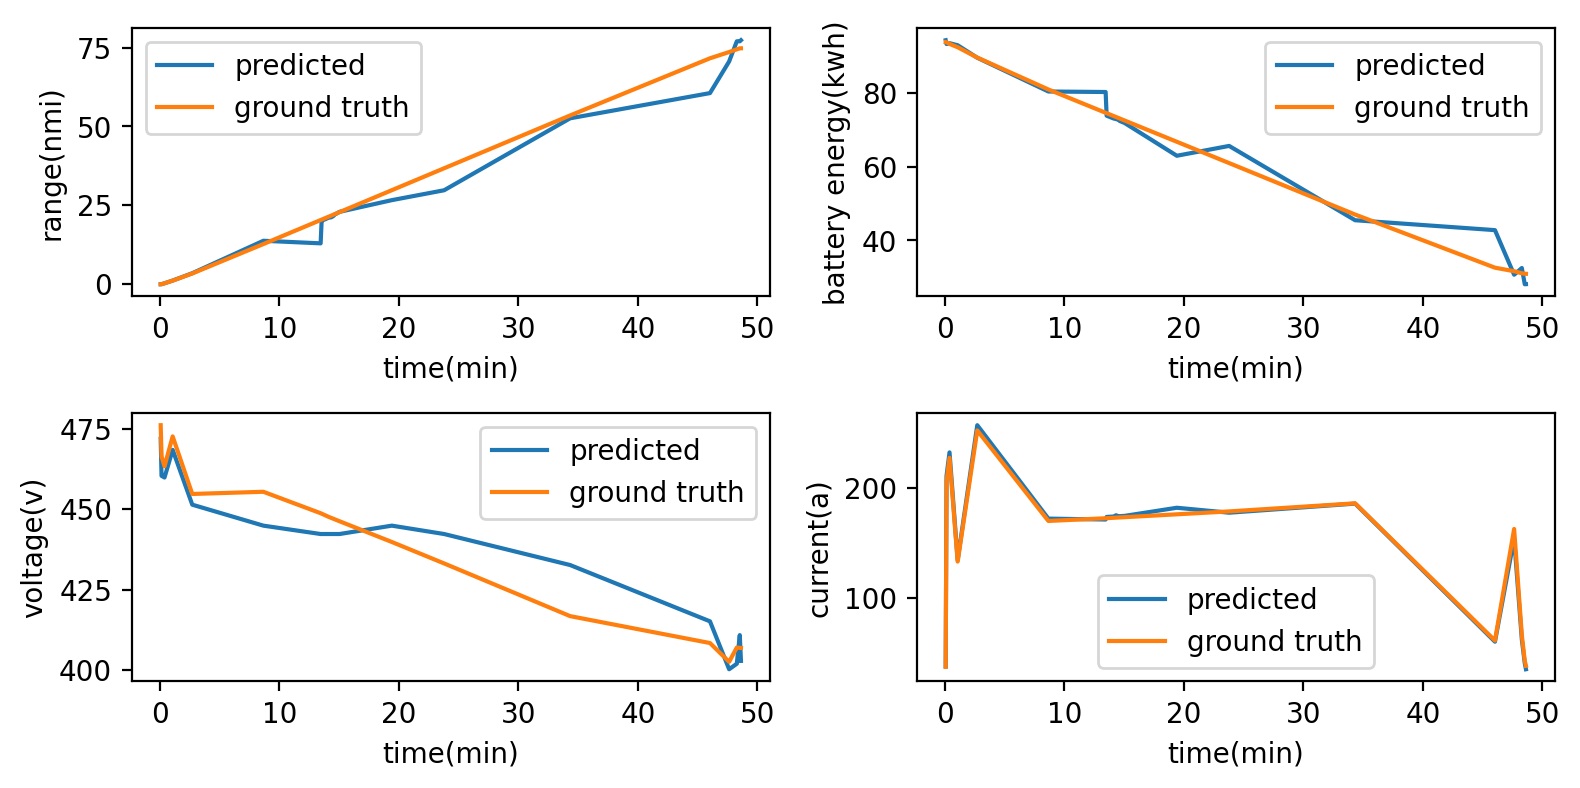

In [51]:
%%time
x_label = 'time(min)'
y_labels = ['range(nmi)', 'battery energy(kwh)', 'voltage(v)', 'current(a)']
subplot_idx = 1
fig = plt.figure(figsize=(8,4), dpi=200)
custom_fn = mape_loss_fn
key = -1
for performance_metric in performance_metrics:
    for idx in performance_metrics[performance_metric]:
        model = tf.keras.models.load_model(model_dir+trained_models_name[subplot_idx-1], 
                                           custom_objects={'mape_loss_fn':custom_fn})
        
        testX, testY, key = get_data_for_lstm_inference(performance_metric, idx, key)
        t = testY[:,-2]
        testX = testX.reshape((-1,1,23))
        testY = testY[:,idx].reshape((-1,1))
        outputs = model.predict(testX)
        # print(testY.shape, outputs.shape)
        y_true = testY.squeeze()
        y_pred = outputs.squeeze()
        
        plt.subplot(2,2,subplot_idx)
        plt.plot(t, y_pred, label='predicted')
        plt.plot(t, y_true, label='ground truth')
        plt.xlabel(x_label)
        plt.ylabel(y_labels[subplot_idx-1])
        plt.legend()
        fig.tight_layout()
        subplot_idx += 1
        
# testX, testY = get_data_for_inference('aircraft_electronics')
# indxes = testY[:,-1]==1
# testX = testX[indxes]
# testY = testY[indxes]
# print(testX.shape, testY.shape)


# y_prev = np.array([[0]])

# y_true = []
# y_pred = []

# for i, x in enumerate(testX):
#     x = x.reshape((1,-1))
#     x = np.concatenate((x,y_prev), axis=1)
#     x = x.reshape((1,1,-1))
#     outputs = model.predict(x)
#     y_true.append(testY[i,3])
#     y_pred.append(outputs[0])
# #     print(y_true[i], y_pred[i])
#     y_prev[0,0] = testY[i,3] #outputs[0]
    
# plt.plot(y_true)
# plt.plot(y_pred)

# show results

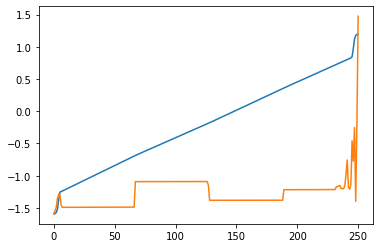

In [190]:
plt.plot(y_true)
plt.plot(y_pred)

# Feasibility Classifier Scores

In [28]:
for key in fesibility_result:
    fes_rslt_df = pd.DataFrame.from_dict(fesibility_result[key])
    print('**********')
    print(key)
    print(fes_rslt_df)

**********
DT
           fesibility
accuracy         0.99
f1               1.00
precision        0.99
recall           1.00
**********
ADBoost
           fesibility
accuracy         0.99
f1               1.00
precision        0.99
recall           1.00
**********
GBoost
           fesibility
accuracy         0.99
f1               1.00
precision        0.99
recall           1.00
**********
RF
           fesibility
accuracy         0.96
f1               0.98
precision        0.99
recall           0.96


# Regressor Scores

## Flight Conditions

In [29]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['flight_conditions'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0            0.00              0.04      412.29
MAE            0.0            0.02              0.02       14.23
MAPE           0.0            0.00              0.00        0.95
**********
ADBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0            0.01              0.00      171.75
MAE            0.0            0.03              0.02       10.20
MAPE           0.0            0.00              0.00        0.66
**********
GBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE           0.00            0.03              0.01      127.43
MAE           0.01            0.09              0.04        8.23
MAPE          0.00            0.00              0.00        4.56
**********
RF
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0            0.01              0.03      141.19
MAE            0.0       

## Aerodynamic Coefficients 

In [30]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['aerodynamic_coefficients'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
       CL   CD  AOA(deg)  L/D
MSE   0.0  0.0      0.00  0.0
MAE   0.0  0.0      0.01  0.0
MAPE  0.0  0.0      0.00  0.0
**********
ADBoost
       CL   CD  AOA(deg)  L/D
MSE   0.0  0.0      0.00  0.0
MAE   0.0  0.0      0.03  0.0
MAPE  0.0  0.0      0.00  0.0
**********
GBoost
       CL   CD  AOA(deg)  L/D
MSE   0.0  0.0      0.01  0.0
MAE   0.0  0.0      0.04  0.0
MAPE  0.0  0.0      0.00  0.0
**********
RF
       CL   CD  AOA(deg)   L/D
MSE   0.0  0.0      0.01  0.00
MAE   0.0  0.0      0.06  0.01
MAPE  0.0  0.0      0.01  0.00


## Aircraft Electronics 

In [31]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['aircraft_electronics'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
       SOC  battery energy(kwh)  battery power(kw)  voltage(v)  voltage oc(v)  \
MSE   0.03               283.08               0.04      364.97         206.71   
MAE   0.12                11.68               0.04       13.09           9.45   
MAPE  0.17                 0.17               0.00        0.03           0.02   

      current(a)  C Rating instant  C Rating nominal  specific power  
MSE        67.45              0.13              0.17            0.15  
MAE         5.28              0.22              0.24            0.08  
MAPE        0.03              0.22              0.24            0.00  
**********
ADBoost
       SOC  battery energy(kwh)  battery power(kw)  voltage(v)  voltage oc(v)  \
MSE   0.02               209.40               0.06      269.35         226.37   
MAE   0.11                11.00               0.10       12.02          11.56   
MAPE  0.16                 0.16               0.00        0.03           0.02   

      current(a)  C Rating instan

##  Electric motor and propeller efficiencies

In [32]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['electric_motor_and_propeller_efficiencies'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      propeller throttle  lift throttle  propeller rpm  propeller thrust(N)  \
MSE                 0.00           0.00           8.32                22.76   
MAE                 0.02           0.01           0.48                 0.66   
MAPE                0.02           0.02           0.00                 0.00   

      propeller torque(Nm)  propeller efficiency  propeller motor efficiency  \
MSE                  94.42                   0.0                         0.0   
MAE                   0.78                   0.0                         0.0   
MAPE                  0.00                   0.0                         0.0   

      propeller power coefficient  lift rotor rpm  lift thrust(N)  \
MSE                           0.0            0.08             0.0   
MAE                           0.0            0.16             0.0   
MAPE                          0.0            0.00             0.0   

      lift torque(Nm)  lift efficiency  lift motor efficiency  \
MSE   

# test

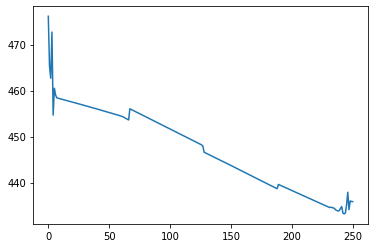

In [56]:
performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
performance = 'aircraft_electronics'   
indx = performances.index(performance)
data_X = None
data_Y = None
for key in range(len(evtol_performance_data_dic)):
    Y = None
    y = evtol_performance_data_dic[key]['outputs'][indx]
    for i in range(0,y.shape[0],8):
        y_row = y.iloc[i:i+8].to_numpy()
        y_row = y_row[:, 2:].astype('float64')
        y_row = np.mean(y_row, axis=0)
        if y_row[-1]==0:
            Y = None
            break
        Y = y_row if Y is None else np.vstack((Y, y_row))
    if Y is None:
        continue
    
    X = None
    x = evtol_performance_data_dic[key]['input']
    evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
    for i in range(x.shape[0]):
        x_row = x.iloc[i].to_numpy()
        x1 = get_one_hot_encode_evtol(evtol_type)
        x2 = get_one_hot_encode_segment(x_row[0])
        x3 = x_row[1:].astype('float64')
        x_row = np.concatenate((x1,x2,x3))
        X = x_row if X is None else np.vstack((X,x_row))
    data_X = X if data_X is None else np.vstack((data_X, X))
    data_Y = Y if data_Y is None else np.vstack((data_Y, Y))


    
#     yield X, Y

In [4]:
!python3.7 --version

Python 3.7.5


In [5]:
import sys
print(sys.version)

3.7.5 (default, Feb 23 2021, 13:22:40) 
[GCC 8.4.0]


In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1451593497158060229
xla_global_id: -1
]


2022-04-12 13:20:45.334966: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 13:20:45.380113: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-12 13:20:45.380176: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ariac
2022-04-12 13:20:45.380190: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ariac
2022-04-12 13:20:45.381072: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-04-12 13:20:45.381135: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 455.45.1
20